# Basic System

This notebook provides code for implementing a very simple machine learning system for named entity recognition.
It uses logistic regression and one feature (the token itself).
Links to information about the packages are provided. Your job is to document the code and use it to train a system. You can then use your evaluation code to provide the first basic evaluation of your system.

*Note:* In the next assignment, you can use this as a basis to experiment with more features and more machine learning methods.

### About this Notebook:
- The notebook is structured similarly to the assignment pdf. Each question contains suggestions to help guide you, but remember to follow the requirements in the PDF for your final answers.

In [1]:
from collections import defaultdict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import sys
import os

# If you want to include other modules, you can add them here
# Please note the recommendations on using modules in the Programming General Guidelines

#recommended resource for examples: https://scikit-learn.org/stable/modules/feature_extraction.html




## 2.1. Load and inspect the data
**Suggestions:**
 - Download the following files form from canvas ,and place them in the folder "`./data/conll2003`":
   - `conll2003.train.conll`, `conll2003.test.conll`, `conll2003.dev.conll`


In [2]:
def extract_features(inputfile):
    """TODO fill in docstring"""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                feature_dict = {'token':token}
                data.append(feature_dict)
    return data

In [3]:
def extract_features_and_labels(trainingfile):
    data = []
    targets = []
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split() # just extract more features in this function to avoid more loops down the road
            if len(components) > 0:  
                token = components[0]
                pos_tag = components[1]
                chunk_tag = components[2]
                ner_tag = components[3]

                feature_dict = {
                    'token': token,
                    'pos_tag': pos_tag,
                    'chunk_tag': chunk_tag,
                    'capitalized': token[0].isupper(),
                    'contains_digit': any(char.isdigit() for char in token),
                    'token_length': len(token)
                }
                
                data.append(feature_dict)
                targets.append(ner_tag)
    return data, targets

In [4]:
def create_dataframe(data, targets):
    """Helper function to turn the datasets into dataframes"""   
    records = []
    for features, target in zip(data, targets):
        record = features.copy()
        record['NER'] = target
        records.append(record)
    
    return pd.DataFrame(records)

In [5]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"

In [6]:
train_data, train_targets = extract_features_and_labels(train_file)
test_data, test_targets = extract_features_and_labels(test_file)
dev_data, dev_targets = extract_features_and_labels(dev_file)

# Create dfs for each set
train_df = create_dataframe(train_data, train_targets)
test_df = create_dataframe(test_data, test_targets)
dev_df = create_dataframe(dev_data, dev_targets)

In [7]:
train_df.head()

,token,pos_tag,chunk_tag,capitalized,contains_digit,token_length,NER
0,EU,NNP,B-NP,True,False,2,B-ORG
1,rejects,VBZ,B-VP,False,False,7,O
2,German,JJ,B-NP,True,False,6,B-MISC
3,call,NN,I-NP,False,False,4,O
4,to,TO,B-VP,False,False,2,O


## 2.2. Data analysis: feature and label distributions
**Suggestions:**

- Inspect which unique NER labels there are and plot their distribution (tip: look into the `Counter()`)
- Evaluate the samples per class to answer the questions in the pdf

### 2.2.1 NER Label Distribution

Distribution of NER Labels:
O: 169578
B-LOC: 7140
B-PER: 6600
B-ORG: 6321
I-PER: 4528
I-ORG: 3704
B-MISC: 3438
I-LOC: 1157
I-MISC: 1155


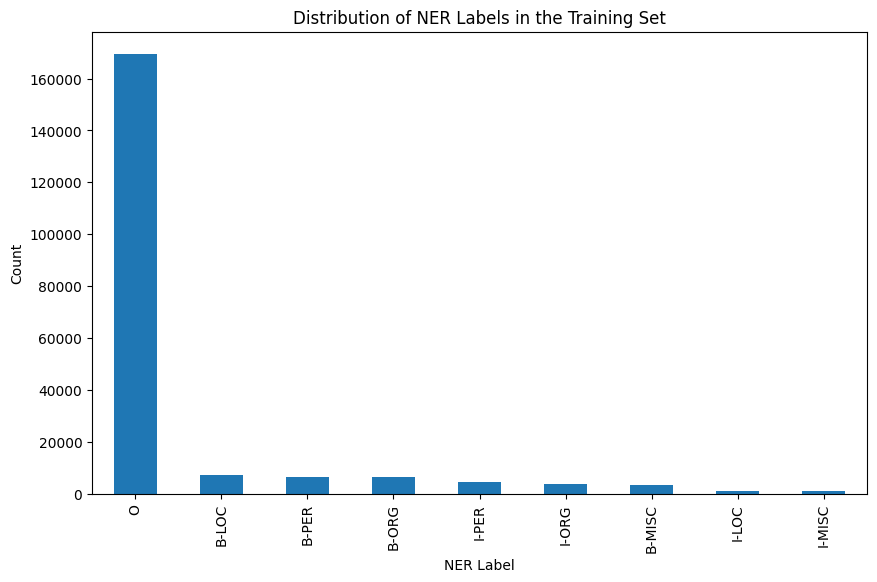

In [8]:
label_counts = train_df['NER'].value_counts()
print("Distribution of NER Labels:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel("NER Label")
plt.ylabel("Count")
plt.title("Distribution of NER Labels in the Training Set")
plt.show()


### 2.2.2 Feature Hypotheses

#### Hypothesis 1: Capitalized words
Capitalized words are more likely to be named entities


Proportion of Capitalized Words by NER Tag:
B-LOC: 1.00
B-MISC: 0.99
B-ORG: 1.00
B-PER: 1.00
I-LOC: 0.96
I-MISC: 0.89
I-ORG: 0.91
I-PER: 0.98
O: 0.07


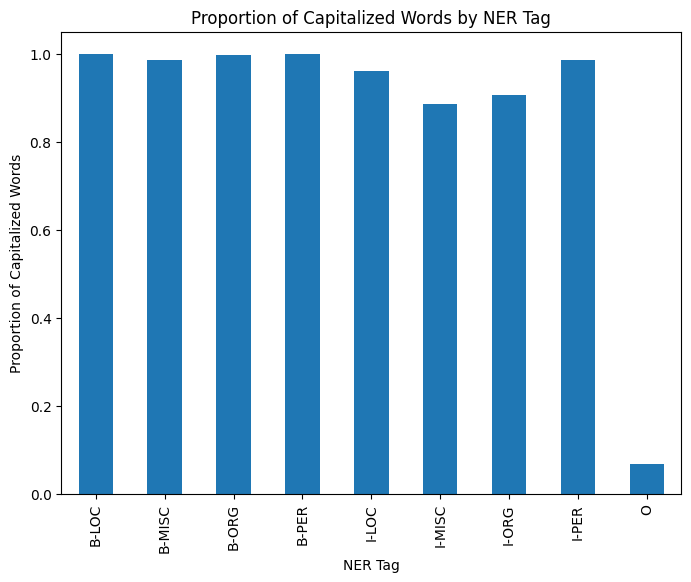

In [9]:
total_counts = train_df['NER'].value_counts()
capitalized_counts = train_df[train_df['capitalized']].groupby('NER').size()
capitalization_ratios = (capitalized_counts / total_counts).fillna(0)  

print("Proportion of Capitalized Words by NER Tag:")
for label, ratio in capitalization_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
capitalization_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of Capitalized Words")
plt.title("Proportion of Capitalized Words by NER Tag")
plt.show()


#### Hypothesis 2: POS Tags
Specific POS tags, are strongly associated with named entities. Test Case: proper nouns (NNP) 

Proportion of NNP-tagged Tokens by NER Tag:
B-LOC: 0.93
B-MISC: 0.44
B-ORG: 0.84
B-PER: 0.93
I-LOC: 0.90
I-MISC: 0.72
I-ORG: 0.82
I-PER: 0.97
O: 0.03


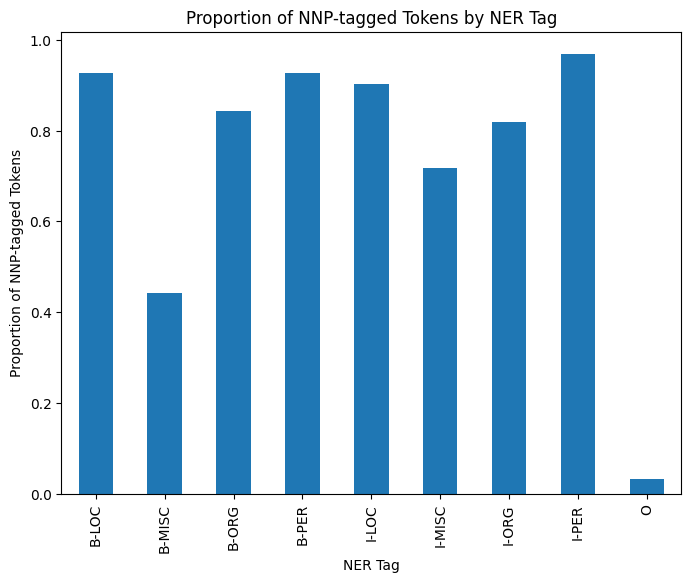

In [10]:
total_counts = train_df['NER'].value_counts()
nnp_counts = train_df[train_df['pos_tag'] == 'NNP'].groupby('NER').size()
nnp_ratios = (nnp_counts / total_counts).fillna(0)  

print("Proportion of NNP-tagged Tokens by NER Tag:")
for label, ratio in nnp_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
nnp_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of NNP-tagged Tokens")
plt.title("Proportion of NNP-tagged Tokens by NER Tag")
plt.show()


#### Hypothesis 3: Token Length
Tokens with longer lengths tend to appear more frequently in categories such as ORG or LOC.

Average Token Length by NER Tag:
B-LOC: 6.38
B-MISC: 6.78
B-ORG: 6.40
B-PER: 5.76
I-LOC: 5.49
I-MISC: 5.46
I-ORG: 6.08
I-PER: 6.50
O: 4.00


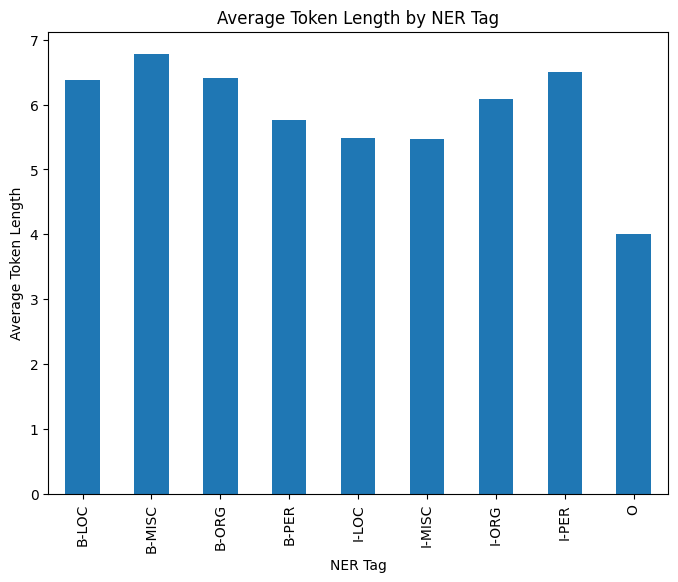

In [11]:
average_token_length = train_df.groupby('NER')['token_length'].mean()
print("Average Token Length by NER Tag:")

for label, avg_length in average_token_length.items():
    print(f"{label}: {avg_length:.2f}")

plt.figure(figsize=(8, 6))
average_token_length.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Average Token Length")
plt.title("Average Token Length by NER Tag")
plt.show()


#### Hypothesis 4: Digit Presence
Tokens containing digits are more likely to be labeled as MISC, as they may indicate numerical identifiers, dates, or events.

Proportion of Tokens with Digits by NER Tag:
B-LOC: 0.00
B-MISC: 0.01
B-ORG: 0.00
B-PER: 0.00
I-LOC: 0.00
I-MISC: 0.05
I-ORG: 0.00
I-PER: 0.00
O: 0.11


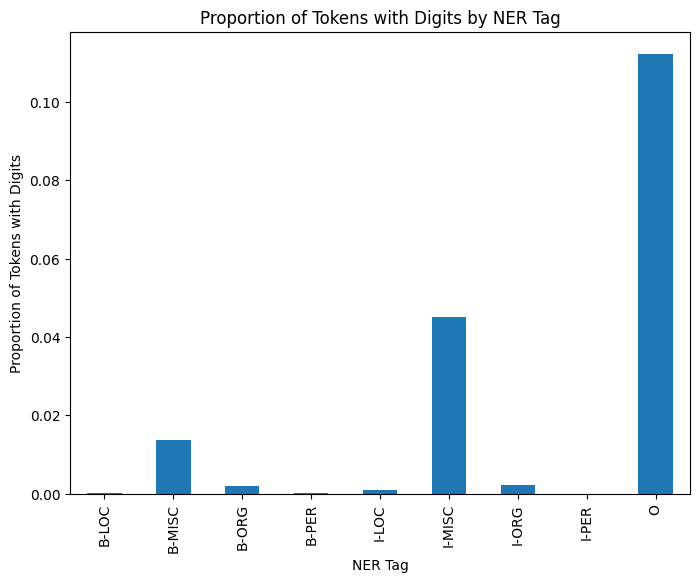

In [12]:
total_counts = train_df['NER'].value_counts()
digit_counts = train_df[train_df['contains_digit']].groupby('NER').size()
digit_ratios = (digit_counts / total_counts).fillna(0)  

print("Proportion of Tokens with Digits by NER Tag:")
for label, ratio in digit_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
digit_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of Tokens with Digits")
plt.title("Proportion of Tokens with Digits by NER Tag")
plt.show()


#### Hypothesis 5: Chunk Tags
Tokens labeled as part of a noun phrase (NP) are more likely to be named entities, as noun phrases often contain names or identifiers.

Proportion of NP-Chunks by NER Tag:
B-LOC: 0.17
B-MISC: 0.51
B-ORG: 0.32
B-PER: 0.33
I-LOC: 0.94
I-MISC: 0.86
I-ORG: 0.87
I-PER: 0.98
O: 0.29


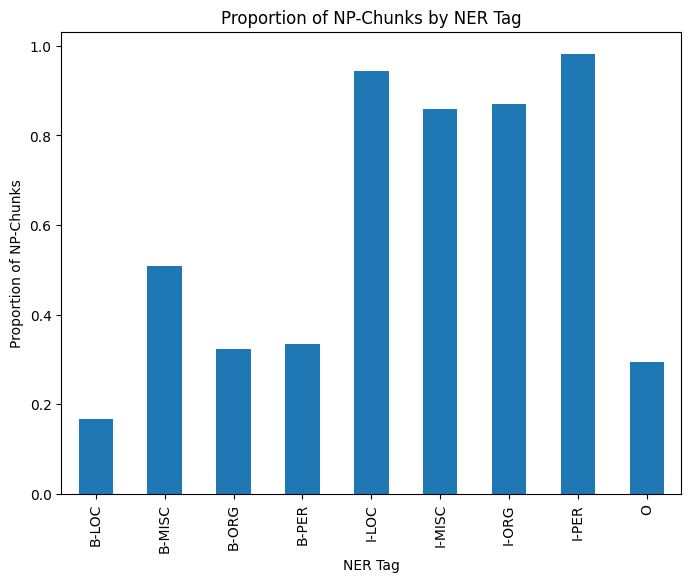

In [13]:
total_counts = train_df['NER'].value_counts()
np_counts = train_df[train_df['chunk_tag'] == 'I-NP'].groupby('NER').size()
np_ratios = (np_counts / total_counts).fillna(0)  

print("Proportion of NP-Chunks by NER Tag:")
for label, ratio in np_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
np_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of NP-Chunks")
plt.title("Proportion of NP-Chunks by NER Tag")
plt.show()


## 2.3. Evaluation

**Suggestions:**
- Create a sample file with the ground_truth features and labels `sample_gt.conll` and a sample prediction file with the predictions `sample_pred.conll`.
- Create a function functions to calculate different metrics from two files: e.g. precision(), recall(), f-score(), confusion_matrix(). (Note you can use packages, e.g. `sklearn`)

In [14]:
def create_sample_conll_files(df, seed, n_rows=10, n_errors=2, data_folder="../../data/tests/"):
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    gt_file = os.path.join(data_folder, "sample_gt.conll")
    pred_file = os.path.join(data_folder, "sample_pred.conll")

    sentence_dfs = []
    sentence = []
    for _, row in df.iterrows():
        if row['token'] == "." and row['NER'] == "O":
            if sentence:
                sentence_dfs.append(pd.DataFrame(sentence))
                sentence = []
        else:
            sentence.append(row)
    if sentence:
        sentence_dfs.append(pd.DataFrame(sentence))  

    random.seed(seed)
    sampled_sentences = []
    total_tokens = 0
    while total_tokens < n_rows and sentence_dfs:
        idx = random.choice(range(len(sentence_dfs)))  
        sentence_df = sentence_dfs.pop(idx)            
        sampled_sentences.append(sentence_df)
        total_tokens += len(sentence_df)

    sample_df = pd.concat(sampled_sentences).reset_index(drop=True)
    ground_truth_data = []
    prediction_data = []

    for _, row in sample_df.iterrows():
        token_line = f"{row['token']} {row['pos_tag']} {row['chunk_tag']} {row['NER']}"
        ground_truth_data.append(token_line)
        prediction_data.append(token_line)  

    error_indices = random.sample(range(len(sample_df)), min(n_errors, len(sample_df)))
    for idx in error_indices:
        original_label = sample_df.loc[idx, 'NER']
        possible_labels = [label for label in df['NER'].unique() if label != original_label]
        new_label = random.choice(possible_labels)

        token, pos, chunk, _ = prediction_data[idx].split()
        prediction_data[idx] = f"{token} {pos} {chunk} {new_label}"

    def write_conll_file(data, file_path):
        with open(file_path, 'w') as f:
            for line in data:
                f.write(line + "\n")

    write_conll_file(ground_truth_data, gt_file)
    write_conll_file(prediction_data, pred_file)

    print(f"Ground truth file '{gt_file}' and prediction file '{pred_file}' created with approximately {n_rows} tokens and {n_errors} errors.")

In [15]:
save_dir = "../../data/tests/"
seed = 42 # Change this to sample a different set
create_sample_conll_files(train_df, seed,  n_rows=100, n_errors=20, data_folder=save_dir)

Ground truth file '../../data/tests/sample_gt.conll' and prediction file '../../data/tests/sample_pred.conll' created with approximately 100 tokens and 20 errors.


In [16]:
def evaluate_ner(gt_file, pred_file):
    def read_labels(file_path):
        labels = []
        with open(file_path, 'r') as f:
            for line in f:
                components = line.strip().split()
                if components:  
                    labels.append(components[-1])  
        return labels

    gt_labels = read_labels(gt_file)
    pred_labels = read_labels(pred_file)

    if len(gt_labels) != len(pred_labels):
        raise ValueError("Ground truth and prediction files must have the same number of labeled tokens.")

    labels = sorted(set(gt_labels + pred_labels))  # Get all unique labels
    cm = confusion_matrix(gt_labels, pred_labels, labels=labels)

    precision = precision_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    recall = recall_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    f1 = f1_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Precision: 0.94
Recall: 0.82
F1-Score: 0.86


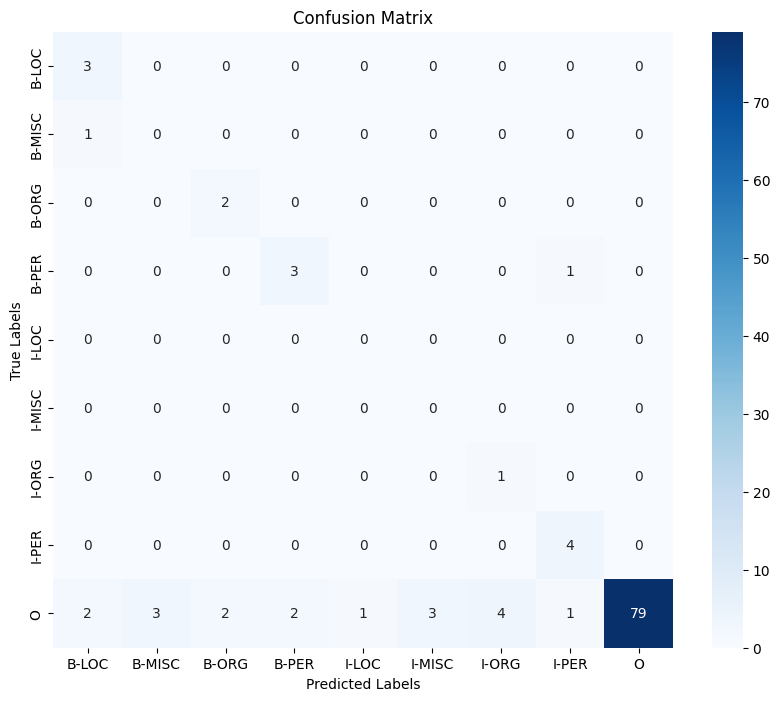

In [17]:
evaluate_ner("../../data/tests/sample_gt.conll", "../../data/tests/sample_pred.conll")

### Spans Evaluation

In [18]:
def read_labels(file_path):
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            components = line.strip().split()
            if components:
                labels.append(components[-1])
    return labels

def extract_spans(labels):
    """
    Extract spans from BIO-labeled sequences.
    Each span is represented as (start_index, end_index, label).
    """
    spans = []
    start = None
    current_label = None

    for i, label in enumerate(labels):
        if label.startswith("B-"):
            if current_label is not None:
                # End the previous span
                spans.append((start, i - 1, current_label))
            # Start a new span
            start = i
            current_label = label[2:]
        elif label.startswith("I-") and current_label == label[2:]:
            # Continue the current span
            continue
        else:
            # End the current span if there is one
            if current_label is not None:
                spans.append((start, i - 1, current_label))
            current_label = None
            start = None

    # Add the last span if it exists
    if current_label is not None:
        spans.append((start, len(labels) - 1, current_label))

    return spans


def span_based_evaluation(gt_file, pred_file, check_spans=False):
    """
    Evaluate precision, recall, and F1-score at the span level.
    """

    gt_labels = read_labels(gt_file)
    pred_labels = read_labels(pred_file)

    if len(gt_labels) != len(pred_labels):
        raise ValueError("Ground truth and prediction files must have the same number of tokens.")

    # Extract spans from ground truth and prediction labels
    gt_spans = set(extract_spans(gt_labels))
    pred_spans = set(extract_spans(pred_labels))

    # Calculate true positives, false positives, and false negatives
    tp = len(gt_spans & pred_spans)  # Correctly predicted spans
    fp = len(pred_spans - gt_spans)  # Predicted spans that don't exist in ground truth
    fn = len(gt_spans - pred_spans)  # Ground truth spans not found in predictions

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Display the results
    if not check_spans:
        print(f"Span-level Precision: {precision:.2f}")
        print(f"Span-level Recall: {recall:.2f}")
        print(f"Span-level F1-Score: {f1:.2f}")
    else:
         print(f"True Spans: {list(gt_spans)[:10]}") # Sanity check


In [19]:
def span_based_evaluation(gt_file, pred_file, check_spans=False):
    """
    Evaluate precision, recall, F1-score, and plot a confusion matrix at the span level.
    """
    
    gt_labels = read_labels(gt_file)
    pred_labels = read_labels(pred_file)

    if len(gt_labels) != len(pred_labels):
        raise ValueError("Ground truth and prediction files must have the same number of tokens.")

    # Extract spans from ground truth and prediction labels
    gt_spans = extract_spans(gt_labels)
    pred_spans = extract_spans(pred_labels)

    # Calculate TP, FP, FN, and TN for each label
    label_counts = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0, "TN": 0})
    
    # Determine TP, FP, and FN for each span
    for span in gt_spans:
        if span in pred_spans:
            label_counts[span[2]]["TP"] += 1  # Correctly predicted
        else:
            label_counts[span[2]]["FN"] += 1  # Missed in prediction (false negative)

    for span in pred_spans:
        if span not in gt_spans:
            label_counts[span[2]]["FP"] += 1  # Incorrectly predicted (false positive)

    # Calculate TN as cases where neither ground truth nor prediction has a span
    all_labels = sorted(set(label for _, _, label in gt_spans + pred_spans))
    for label in all_labels:
        other_labels = set(all_labels) - {label}
        tn_count = sum(label_counts[other_label]["FN"] + label_counts[other_label]["TP"] for other_label in other_labels)
        label_counts[label]["TN"] = tn_count

    # Calculate precision, recall, and F1-score for each label
    precisions, recalls, f1_scores = {}, {}, {}
    for label in all_labels:
        tp = label_counts[label]["TP"]
        fp = label_counts[label]["FP"]
        fn = label_counts[label]["FN"]
        tn = label_counts[label]["TN"]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions[label] = precision
        recalls[label] = recall
        f1_scores[label] = f1

        print(f"{label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    # Build confusion matrix including TNs
    matrix = []
    for true_label in all_labels:
        row = []
        for pred_label in all_labels:
            if true_label == pred_label:
                row.append(label_counts[true_label]["TP"])
            else:
                row.append(label_counts[pred_label]["FP"] if pred_label in label_counts else 0)
        row.append(label_counts[true_label]["TN"])  # Add TN for each label
        matrix.append(row)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels + ["TN"], yticklabels=all_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Span-Level Confusion Matrix")
    plt.show()

    # Calculate overall metrics
    overall_tp = sum(counts["TP"] for counts in label_counts.values())
    overall_fp = sum(counts["FP"] for counts in label_counts.values())
    overall_fn = sum(counts["FN"] for counts in label_counts.values())
    overall_tn = sum(counts["TN"] for counts in label_counts.values())

    overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
    overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
    overall_f1 = (2 * overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"\nOverall - Precision: {overall_precision:.2f}, Recall: {overall_recall:.2f}, F1-Score: {overall_f1:.2f}")


LOC - Precision: 0.50, Recall: 1.00, F1-Score: 0.67
MISC - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
ORG - Precision: 0.50, Recall: 1.00, F1-Score: 0.67
PER - Precision: 0.60, Recall: 0.75, F1-Score: 0.67


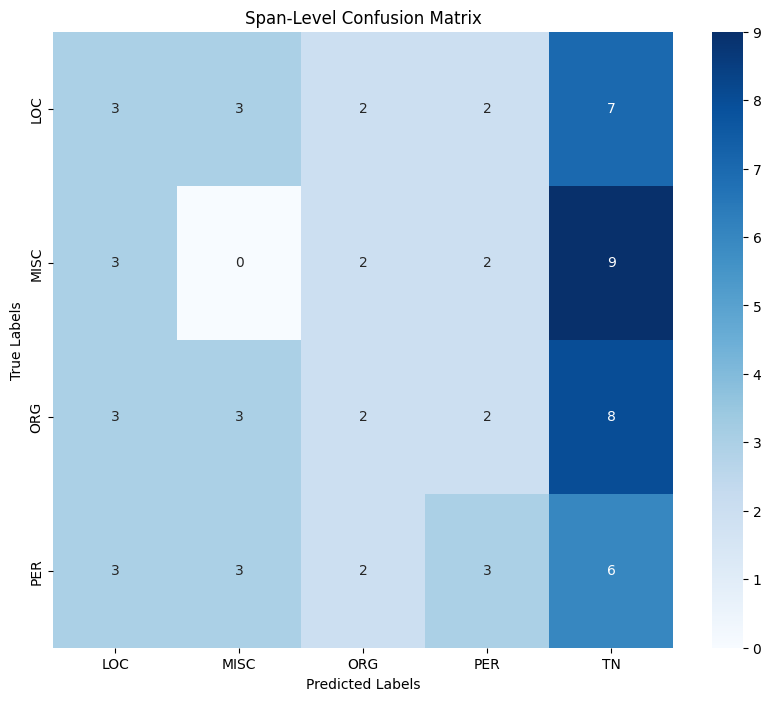


Overall - Precision: 0.44, Recall: 0.80, F1-Score: 0.57


In [20]:
span_based_evaluation("../../data/tests/sample_gt.conll", "../../data/tests/sample_pred.conll", check_spans=False) # Set this to true to visualize spans and compare with file

## 2.4. Train and evaluate basic NERC system
**Suggestions:**
- Train the Logistic regression classifier on your dataset and evaluate the performance on your various metrics.
- Transfer your code to a python file 

In [21]:
def create_classifier(train_features, train_targets):
    """TODO fill in docstring"""
    logreg = LogisticRegression()
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = logreg.fit(features_vectorized, train_targets)
    
    return model, vec

In [22]:
def classify_data(model, vec, inputdata, outputfile):
    """TODO fill in docstring"""
    features = extract_features(inputdata)
    features = vec.transform(features)
    predictions = model.predict(features)
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()

### (**optional**) 2.4.2 Convert to a python file:
- This is part is optional for now but will be required for assignment 2, so it is good practice.

Description:
- To convert the code to a python file, you should place all the relevant functions in one `.py` file.
- Add the following lines to the bottom, which ensure that if you call the function from a terminal, the lines within it will be exectued:


In [23]:
def main(argv=None):
    """TODO fill in docstring"""

    #a very basic way for picking up commandline arguments
    if argv is None:
        argv = sys.argv
        
    #Note 1: argv[0] is the name of the python program if you run your program as: python program1.py arg1 arg2 arg3
    #Note 2: sys.argv is simple, but gets messy if you need it for anything else than basic scenarios with few arguments
    #you'll want to move to something better. e.g. argparse (easy to find online)
    
    
    #you can replace the values for these with paths to the appropriate files for now, e.g. by specifying values in argv
    #argv = ['mypython_program','','','']
    trainingfile = argv[1]
    inputfile = argv[2]
    outputfile = argv[3]
    
    training_features, gold_labels = extract_features_and_labels(trainingfile)
    ml_model, vec = create_classifier(training_features, gold_labels)
    classify_data(ml_model, vec, inputfile, outputfile)

# uncomment this when using this in a script    
if __name__ == '__main__':
    # Code below is executed when this python file is called from terminal
    main()


IndexError: list index out of range

In [ ]:
# remember that the first element of the list is not used 
# (since this is the `python command when the args are read from sys.argv)
# make sure to complete the rest of the list assigned to args correctly
args = ['python']
main(args)